> In this notebook, we train the bbbc-model on various variations of manually annotated images from the aits-lab
> 
> The model is trained and evaluated using cross-validation. The best performing model will be trained further

##### Imports

In [1]:
import sys
import os

import numpy as np
import skimage.io

import tensorflow as tf

import keras.backend
import keras.callbacks
import keras.layers
import keras.models
import keras.optimizers

import utils.model_builder
import utils.data_provider
import utils.metrics
import utils.objectives
import utils.dirtools

# Uncomment the following line if you don't have a GPU
#os.environ['CUDA_VISIBLE_DEVICES'] = ''

Using TensorFlow backend.


In [41]:
import matplotlib.pyplot as plt


##### set session

In [72]:
# build session running on GPU 1
configuration = tf.compat.v1.ConfigProto()
configuration.gpu_options.allow_growth = True
configuration.gpu_options.visible_device_list = "0"
session = tf.compat.v1.Session(config = configuration)

# apply session
tf.compat.v1.keras.backend.set_session(session)

##### load images

In [7]:
all_images = sorted(os.listdir('/home/fvitez/nuclei_detection/aitslab_boundary_labels/all_images/'))

In [8]:
all_images

['MFGTMPcx7_170702000001_G07f02d0.png',
 'MFGTMPcx7_170702090001_B22f15d0.png',
 'MFGTMPcx7_170702090001_N06f14d0.png',
 'MFGTMPcx7_170731090001_K24f10d0.png',
 'MFGTMPcx7_170801050001_A01f03d0.png',
 'MFGTMPcx7_170803210001_A01f29d0.png',
 'MFGTMPcx7_170803210001_A05f27d0.png',
 'MFGTMPcx7_170803210001_B18f27d0.png',
 'MFGTMPcx7_170803210001_B19f26d0.png',
 'MFGTMPcx7_170803210001_J12f29d0.png']

#### Model 2: BBBC + Manually annotated

In [77]:
config_vars = {'root_directory': '/home/fvitez/nuclei_detection/',
 'max_training_images': 0,
 'create_split_files': False,
 'training_fraction': 0.5,
 'validation_fraction': 0.25,
 'transform_images_to_PNG': True,
 'pixel_depth': 8,
 'min_nucleus_size': 25,
 'boundary_size': 2,
 'augment_images': False,
 'elastic_points': 16,
 'elastic_distortion': 5,
 'elastic_augmentations': 10,
 'learning_rate': 0.0001,
 'epochs': 15,
 'steps_per_epoch': 500,
 'batch_size': 9 ,
 'val_batch_size': 1,
 'rescale_labels': True,
 'crop_size': 256,
 'cell_min_size': 16,
 'boundary_boost_factor': 1,
 'object_dilation': 3,
 'raw_images_dir': '/home/fvitez/nuclei_detection/raw_images/',
 'raw_annotations_dir': '/home/fvitez/nuclei_detection/raw_annotations/',
 'path_files_training': '/home/fvitez/nuclei_detection/training.txt',
 'path_files_validation': '/home/fvitez/nuclei_detection/validation.txt',
 'path_files_test': '/home/fvitez/nuclei_detection/test.txt',
 'normalized_images_dir': '/home/fvitez/nuclei_detection/resized_aitslab_png_images/',
 'boundary_labels_dir': '/home/fvitez/nuclei_detection/aitslab_boundary_labels/resized_images/',
 'experiment_dir': '/home/fvitez/nuclei_detection/experiments/bbbc/out/',
 'probmap_out_dir': '/home/fvitez/nuclei_detection/experiments/bbbc/out/prob/',
 'labels_out_dir': '/home/fvitez/nuclei_detection/experiments/bbbc/out/segm/',
 'model_file': '/home/fvitez/nuclei_detection/experiments/bbbc/model.hdf5',
 'csv_log_file': '/home/fvitez/nuclei_detection/experiments/bbbc/log.csv'}

In [78]:
experiment_name = 'model_2' 

config_vars = utils.dirtools.setup_experiment(config_vars, experiment_name)

data_partitions = utils.dirtools.read_data_partitions(config_vars)

#config_vars

/home/fvitez/nuclei_detection/utils/model_builder.py:16: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
  a = keras.layers.Convolution2D(64, 3, 3, **option_dict_conv)(x)
/home/fvitez/nuclei_detection/utils/model_builder.py:17: UserWarning: Update your `BatchNormalization` call to the Keras 2 API: `BatchNormalization(momentum=0.9)`
  a = keras.layers.BatchNormalization(**option_dict_bn)(a)
/home/fvitez/nuclei_detection/utils/model_builder.py:19: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
  a = keras.layers.Convolution2D(64, 3, 3, **option_dict_conv)(a)
/home/fvitez/nuclei_detection/utils/model_builder.py:20: UserWarning: Update your `BatchNormalization` call to the Keras 2 API: `BatchNormalization(momentum=0.9)`
  a = keras.layers.BatchNormalization(**option_dict_bn)(a)
/home/fvitez/nuclei_detection/utils/model_builder.py:25: UserWarning: Update you

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_46 (Conv2D)              (None, 256, 256, 64) 640         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_43 (BatchNo (None, 256, 256, 64) 256         conv2d_46[0][0]                  
__________________________________________________________________________________________________
conv2d_47 (Conv2D)              (None, 256, 256, 64) 36928       batch_normalization_43[0][0]     
____________________________________________________________________________________________

##### perform cross-validation

In [89]:
statistics.history['val_boundary_precision'][2]

0.18667466938495636

In [90]:
#training = all_images[1:]
accumulated_val_boundary_precision = 0
accumulated_val_loss = 0

for i in range(0,9):
    test = [all_images[i]]
    training = [item for item in all_images if item not in test]
    
    # build model
    model = utils.model_builder.get_model_3_class(config_vars["crop_size"], config_vars["crop_size"], activation=None)
    model.load_weights('/home/fvitez/nuclei_detection/experiments/bbbc/model.hdf5')
    #model.summary()

    #loss = "categorical_crossentropy"
    loss = utils.objectives.weighted_crossentropy

    metrics = [keras.metrics.categorical_accuracy, 
               utils.metrics.channel_recall(channel=0, name="background_recall"), 
               utils.metrics.channel_precision(channel=0, name="background_precision"),
               utils.metrics.channel_recall(channel=1, name="interior_recall"), 
               utils.metrics.channel_precision(channel=1, name="interior_precision"),
               utils.metrics.channel_recall(channel=2, name="boundary_recall"), 
               utils.metrics.channel_precision(channel=2, name="boundary_precision"),
              ]

    optimizer = keras.optimizers.RMSprop(lr=config_vars["learning_rate"])

    model.compile(loss=loss, metrics=metrics, optimizer=optimizer)

    # Performance logging
    callback_csv = keras.callbacks.CSVLogger(filename=config_vars["csv_log_file"])

    callbacks=[callback_csv]
    
    #print(test)
    #print(training)
    #break
    data_partitions['training'] = training
    data_partitions['validation'] = test
    train_gen = utils.data_provider.random_sample_generator(
        config_vars["normalized_images_dir"],
        config_vars["boundary_labels_dir"],
        data_partitions["training"],
        config_vars["batch_size"],
        config_vars["pixel_depth"],
        config_vars["crop_size"],
        config_vars["crop_size"],
        config_vars["rescale_labels"],
        False # no augm. except for cropping
    )

    val_gen = utils.data_provider.single_data_from_images(
         config_vars["normalized_images_dir"],
         config_vars["boundary_labels_dir"],
         data_partitions["validation"],
         config_vars["val_batch_size"],
         config_vars["pixel_depth"],
         config_vars["crop_size"],
         config_vars["crop_size"],
         config_vars["rescale_labels"]
    )
    
    # TRAIN
    statistics = model.fit_generator(
        generator=train_gen,
        steps_per_epoch=5,
        #epochs=config_vars["epochs"],
        epochs = 3,
        validation_data=val_gen,
        validation_steps=1,
        callbacks=callbacks,
        verbose = 1
    )
    accumulated_val_boundary_precision += statistics.history['val_boundary_precision'][2]
    accumulated_val_loss += statistics.history['val_loss'][2]
    

    print(str(i) + " out of " + str(10) + ' Done! :)')

print("Mean validation boundary precision = " + str(accumulated_val_boundary_precision/10))
print("Mean validation loss = " + str(accumulated_val_loss/10))

    

/home/fvitez/nuclei_detection/utils/model_builder.py:16: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
  a = keras.layers.Convolution2D(64, 3, 3, **option_dict_conv)(x)
/home/fvitez/nuclei_detection/utils/model_builder.py:17: UserWarning: Update your `BatchNormalization` call to the Keras 2 API: `BatchNormalization(momentum=0.9)`
  a = keras.layers.BatchNormalization(**option_dict_bn)(a)
/home/fvitez/nuclei_detection/utils/model_builder.py:19: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
  a = keras.layers.Convolution2D(64, 3, 3, **option_dict_conv)(a)
/home/fvitez/nuclei_detection/utils/model_builder.py:20: UserWarning: Update your `BatchNormalization` call to the Keras 2 API: `BatchNormalization(momentum=0.9)`
  a = keras.layers.BatchNormalization(**option_dict_bn)(a)
/home/fvitez/nuclei_detection/utils/model_builder.py:25: UserWarning: Update you

Training with 9 images.
Epoch 1/3
5/5 [==============================] - 52s 10s/step - loss: 0.4773 - categorical_accuracy: 0.8670 - background_recall: 0.8669 - background_precision: 0.9994 - interior_recall: 0.8817 - interior_precision: 0.5343 - boundary_recall: 0.8234 - boundary_precision: 0.1441 - val_loss: 0.2094 - val_categorical_accuracy: 0.9637 - val_background_recall: 0.9722 - val_background_precision: 0.9997 - val_interior_recall: 0.6890 - val_interior_precision: 0.7897 - val_boundary_recall: 0.9512 - val_boundary_precision: 0.1344
Epoch 2/3
5/5 [==============================] - 43s 9s/step - loss: 0.2891 - categorical_accuracy: 0.9641 - background_recall: 0.9703 - background_precision: 0.9992 - interior_recall: 0.8890 - interior_precision: 0.7959 - boundary_recall: 0.8131 - boundary_precision: 0.2429 - val_loss: 0.1637 - val_categorical_accuracy: 0.9633 - val_background_recall: 0.9707 - val_background_precision: 0.9998 - val_interior_recall: 0.7284 - val_interior_precision:

/home/fvitez/nuclei_detection/utils/model_builder.py:16: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
  a = keras.layers.Convolution2D(64, 3, 3, **option_dict_conv)(x)
/home/fvitez/nuclei_detection/utils/model_builder.py:17: UserWarning: Update your `BatchNormalization` call to the Keras 2 API: `BatchNormalization(momentum=0.9)`
  a = keras.layers.BatchNormalization(**option_dict_bn)(a)
/home/fvitez/nuclei_detection/utils/model_builder.py:19: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
  a = keras.layers.Convolution2D(64, 3, 3, **option_dict_conv)(a)
/home/fvitez/nuclei_detection/utils/model_builder.py:20: UserWarning: Update your `BatchNormalization` call to the Keras 2 API: `BatchNormalization(momentum=0.9)`
  a = keras.layers.BatchNormalization(**option_dict_bn)(a)
/home/fvitez/nuclei_detection/utils/model_builder.py:25: UserWarning: Update you

Training with 9 images.
Epoch 1/3
5/5 [==============================] - 55s 11s/step - loss: 0.4855 - categorical_accuracy: 0.8612 - background_recall: 0.8603 - background_precision: 0.9997 - interior_recall: 0.8925 - interior_precision: 0.4888 - boundary_recall: 0.8344 - boundary_precision: 0.1388 - val_loss: 0.4531 - val_categorical_accuracy: 0.9126 - val_background_recall: 0.9308 - val_background_precision: 0.9972 - val_interior_recall: 0.7449 - val_interior_precision: 0.8028 - val_boundary_recall: 0.8254 - val_boundary_precision: 0.1475
Epoch 2/3
5/5 [==============================] - 44s 9s/step - loss: 0.2862 - categorical_accuracy: 0.9633 - background_recall: 0.9679 - background_precision: 0.9995 - interior_recall: 0.9023 - interior_precision: 0.7476 - boundary_recall: 0.8147 - boundary_precision: 0.2312 - val_loss: 0.3701 - val_categorical_accuracy: 0.9162 - val_background_recall: 0.9383 - val_background_precision: 0.9975 - val_interior_recall: 0.7063 - val_interior_precision:

/home/fvitez/nuclei_detection/utils/model_builder.py:16: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
  a = keras.layers.Convolution2D(64, 3, 3, **option_dict_conv)(x)
/home/fvitez/nuclei_detection/utils/model_builder.py:17: UserWarning: Update your `BatchNormalization` call to the Keras 2 API: `BatchNormalization(momentum=0.9)`
  a = keras.layers.BatchNormalization(**option_dict_bn)(a)
/home/fvitez/nuclei_detection/utils/model_builder.py:19: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
  a = keras.layers.Convolution2D(64, 3, 3, **option_dict_conv)(a)
/home/fvitez/nuclei_detection/utils/model_builder.py:20: UserWarning: Update your `BatchNormalization` call to the Keras 2 API: `BatchNormalization(momentum=0.9)`
  a = keras.layers.BatchNormalization(**option_dict_bn)(a)
/home/fvitez/nuclei_detection/utils/model_builder.py:25: UserWarning: Update you

Training with Epoch 1/39 images.

5/5 [==============================] - 53s 11s/step - loss: 0.4542 - categorical_accuracy: 0.8819 - background_recall: 0.8827 - background_precision: 0.9991 - interior_recall: 0.8841 - interior_precision: 0.5900 - boundary_recall: 0.8265 - boundary_precision: 0.1662 - val_loss: 0.2200 - val_categorical_accuracy: 0.9630 - val_background_recall: 0.9821 - val_background_precision: 0.9995 - val_interior_recall: 0.7057 - val_interior_precision: 0.9747 - val_boundary_recall: 0.9596 - val_boundary_precision: 0.2347
Epoch 2/3
5/5 [==============================] - 43s 9s/step - loss: 0.2708 - categorical_accuracy: 0.9697 - background_recall: 0.9757 - background_precision: 0.9992 - interior_recall: 0.8965 - interior_precision: 0.8243 - boundary_recall: 0.8136 - boundary_precision: 0.2741 - val_loss: 0.2059 - val_categorical_accuracy: 0.9659 - val_background_recall: 0.9831 - val_background_precision: 0.9991 - val_interior_recall: 0.7397 - val_interior_precision:

/home/fvitez/nuclei_detection/utils/model_builder.py:16: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
  a = keras.layers.Convolution2D(64, 3, 3, **option_dict_conv)(x)
/home/fvitez/nuclei_detection/utils/model_builder.py:17: UserWarning: Update your `BatchNormalization` call to the Keras 2 API: `BatchNormalization(momentum=0.9)`
  a = keras.layers.BatchNormalization(**option_dict_bn)(a)
/home/fvitez/nuclei_detection/utils/model_builder.py:19: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
  a = keras.layers.Convolution2D(64, 3, 3, **option_dict_conv)(a)
/home/fvitez/nuclei_detection/utils/model_builder.py:20: UserWarning: Update your `BatchNormalization` call to the Keras 2 API: `BatchNormalization(momentum=0.9)`
  a = keras.layers.BatchNormalization(**option_dict_bn)(a)
/home/fvitez/nuclei_detection/utils/model_builder.py:25: UserWarning: Update you

Training with 9 images.
Epoch 1/3
5/5 [==============================] - 52s 10s/step - loss: 0.4539 - categorical_accuracy: 0.8807 - background_recall: 0.8817 - background_precision: 0.9992 - interior_recall: 0.8837 - interior_precision: 0.5863 - boundary_recall: 0.8195 - boundary_precision: 0.1613 - val_loss: 0.0627 - val_categorical_accuracy: 0.9918 - val_background_recall: 0.9960 - val_background_precision: 1.0000 - val_interior_recall: 0.7096 - val_interior_precision: 0.9886 - val_boundary_recall: 1.0000 - val_boundary_precision: 0.2345
Epoch 2/3
5/5 [==============================] - 43s 9s/step - loss: 0.2620 - categorical_accuracy: 0.9715 - background_recall: 0.9777 - background_precision: 0.9991 - interior_recall: 0.8953 - interior_precision: 0.8545 - boundary_recall: 0.8254 - boundary_precision: 0.2874 - val_loss: 0.0621 - val_categorical_accuracy: 0.9913 - val_background_recall: 0.9954 - val_background_precision: 1.0000 - val_interior_recall: 0.7229 - val_interior_precision:

/home/fvitez/nuclei_detection/utils/model_builder.py:16: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
  a = keras.layers.Convolution2D(64, 3, 3, **option_dict_conv)(x)
/home/fvitez/nuclei_detection/utils/model_builder.py:17: UserWarning: Update your `BatchNormalization` call to the Keras 2 API: `BatchNormalization(momentum=0.9)`
  a = keras.layers.BatchNormalization(**option_dict_bn)(a)
/home/fvitez/nuclei_detection/utils/model_builder.py:19: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
  a = keras.layers.Convolution2D(64, 3, 3, **option_dict_conv)(a)
/home/fvitez/nuclei_detection/utils/model_builder.py:20: UserWarning: Update your `BatchNormalization` call to the Keras 2 API: `BatchNormalization(momentum=0.9)`
  a = keras.layers.BatchNormalization(**option_dict_bn)(a)
/home/fvitez/nuclei_detection/utils/model_builder.py:25: UserWarning: Update you

Epoch 1/3
Training with 9 images.
5/5 [==============================] - 52s 10s/step - loss: 0.4459 - categorical_accuracy: 0.8853 - background_recall: 0.8861 - background_precision: 0.9993 - interior_recall: 0.8877 - interior_precision: 0.5615 - boundary_recall: 0.8245 - boundary_precision: 0.1622 - val_loss: 0.2664 - val_categorical_accuracy: 0.9526 - val_background_recall: 0.9776 - val_background_precision: 0.9987 - val_interior_recall: 0.7313 - val_interior_precision: 0.9588 - val_boundary_recall: 0.8879 - val_boundary_precision: 0.2426
Epoch 2/3
5/5 [==============================] - 42s 8s/step - loss: 0.2761 - categorical_accuracy: 0.9663 - background_recall: 0.9715 - background_precision: 0.9993 - interior_recall: 0.9007 - interior_precision: 0.8066 - boundary_recall: 0.8065 - boundary_precision: 0.2432 - val_loss: 0.2637 - val_categorical_accuracy: 0.9559 - val_background_recall: 0.9776 - val_background_precision: 0.9986 - val_interior_recall: 0.7670 - val_interior_precision:

/home/fvitez/nuclei_detection/utils/model_builder.py:16: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
  a = keras.layers.Convolution2D(64, 3, 3, **option_dict_conv)(x)
/home/fvitez/nuclei_detection/utils/model_builder.py:17: UserWarning: Update your `BatchNormalization` call to the Keras 2 API: `BatchNormalization(momentum=0.9)`
  a = keras.layers.BatchNormalization(**option_dict_bn)(a)
/home/fvitez/nuclei_detection/utils/model_builder.py:19: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
  a = keras.layers.Convolution2D(64, 3, 3, **option_dict_conv)(a)
/home/fvitez/nuclei_detection/utils/model_builder.py:20: UserWarning: Update your `BatchNormalization` call to the Keras 2 API: `BatchNormalization(momentum=0.9)`
  a = keras.layers.BatchNormalization(**option_dict_bn)(a)
/home/fvitez/nuclei_detection/utils/model_builder.py:25: UserWarning: Update you

Epoch 1/3Training with 9 images.

5/5 [==============================] - 52s 10s/step - loss: 0.4438 - categorical_accuracy: 0.8873 - background_recall: 0.8887 - background_precision: 0.9992 - interior_recall: 0.8859 - interior_precision: 0.6054 - boundary_recall: 0.8215 - boundary_precision: 0.1607 - val_loss: 0.3598 - val_categorical_accuracy: 0.9350 - val_background_recall: 0.9628 - val_background_precision: 0.9979 - val_interior_recall: 0.6822 - val_interior_precision: 0.9563 - val_boundary_recall: 0.8762 - val_boundary_precision: 0.1969
Epoch 2/3
5/5 [==============================] - 43s 9s/step - loss: 0.2790 - categorical_accuracy: 0.9674 - background_recall: 0.9731 - background_precision: 0.9993 - interior_recall: 0.8960 - interior_precision: 0.8319 - boundary_recall: 0.8194 - boundary_precision: 0.2595 - val_loss: 0.3567 - val_categorical_accuracy: 0.9349 - val_background_recall: 0.9586 - val_background_precision: 0.9988 - val_interior_recall: 0.7173 - val_interior_precision:

/home/fvitez/nuclei_detection/utils/model_builder.py:16: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
  a = keras.layers.Convolution2D(64, 3, 3, **option_dict_conv)(x)
/home/fvitez/nuclei_detection/utils/model_builder.py:17: UserWarning: Update your `BatchNormalization` call to the Keras 2 API: `BatchNormalization(momentum=0.9)`
  a = keras.layers.BatchNormalization(**option_dict_bn)(a)
/home/fvitez/nuclei_detection/utils/model_builder.py:19: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
  a = keras.layers.Convolution2D(64, 3, 3, **option_dict_conv)(a)
/home/fvitez/nuclei_detection/utils/model_builder.py:20: UserWarning: Update your `BatchNormalization` call to the Keras 2 API: `BatchNormalization(momentum=0.9)`
  a = keras.layers.BatchNormalization(**option_dict_bn)(a)
/home/fvitez/nuclei_detection/utils/model_builder.py:25: UserWarning: Update you

Training with 9 images.
Epoch 1/3
5/5 [==============================] - 52s 10s/step - loss: 0.4377 - categorical_accuracy: 0.8902 - background_recall: 0.8918 - background_precision: 0.9992 - interior_recall: 0.8873 - interior_precision: 0.6193 - boundary_recall: 0.8254 - boundary_precision: 0.1777 - val_loss: 0.1395 - val_categorical_accuracy: 0.9770 - val_background_recall: 0.9820 - val_background_precision: 1.0000 - val_interior_recall: 0.7127 - val_interior_precision: 0.8816 - val_boundary_recall: 0.8333 - val_boundary_precision: 0.1053
Epoch 2/3
5/5 [==============================] - 42s 8s/step - loss: 0.2504 - categorical_accuracy: 0.9741 - background_recall: 0.9808 - background_precision: 0.9990 - interior_recall: 0.8977 - interior_precision: 0.8974 - boundary_recall: 0.8287 - boundary_precision: 0.3129 - val_loss: 0.1321 - val_categorical_accuracy: 0.9766 - val_background_recall: 0.9815 - val_background_precision: 1.0000 - val_interior_recall: 0.7173 - val_interior_precision:

/home/fvitez/nuclei_detection/utils/model_builder.py:16: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
  a = keras.layers.Convolution2D(64, 3, 3, **option_dict_conv)(x)
/home/fvitez/nuclei_detection/utils/model_builder.py:17: UserWarning: Update your `BatchNormalization` call to the Keras 2 API: `BatchNormalization(momentum=0.9)`
  a = keras.layers.BatchNormalization(**option_dict_bn)(a)
/home/fvitez/nuclei_detection/utils/model_builder.py:19: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
  a = keras.layers.Convolution2D(64, 3, 3, **option_dict_conv)(a)
/home/fvitez/nuclei_detection/utils/model_builder.py:20: UserWarning: Update your `BatchNormalization` call to the Keras 2 API: `BatchNormalization(momentum=0.9)`
  a = keras.layers.BatchNormalization(**option_dict_bn)(a)
/home/fvitez/nuclei_detection/utils/model_builder.py:25: UserWarning: Update you

Epoch 1/3
Training with 9 images.
5/5 [==============================] - 52s 10s/step - loss: 0.4399 - categorical_accuracy: 0.8915 - background_recall: 0.8926 - background_precision: 0.9992 - interior_recall: 0.8887 - interior_precision: 0.5941 - boundary_recall: 0.8264 - boundary_precision: 0.1840 - val_loss: 0.3500 - val_categorical_accuracy: 0.9402 - val_background_recall: 0.9634 - val_background_precision: 0.9998 - val_interior_recall: 0.6259 - val_interior_precision: 0.9048 - val_boundary_recall: 0.8790 - val_boundary_precision: 0.1540
Epoch 2/3
5/5 [==============================] - 43s 9s/step - loss: 0.2686 - categorical_accuracy: 0.9702 - background_recall: 0.9758 - background_precision: 0.9992 - interior_recall: 0.9037 - interior_precision: 0.8390 - boundary_recall: 0.8269 - boundary_precision: 0.2924 - val_loss: 0.2882 - val_categorical_accuracy: 0.9516 - val_background_recall: 0.9672 - val_background_precision: 0.9998 - val_interior_recall: 0.7485 - val_interior_precision:

/home/fvitez/nuclei_detection/utils/model_builder.py:16: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
  a = keras.layers.Convolution2D(64, 3, 3, **option_dict_conv)(x)
/home/fvitez/nuclei_detection/utils/model_builder.py:17: UserWarning: Update your `BatchNormalization` call to the Keras 2 API: `BatchNormalization(momentum=0.9)`
  a = keras.layers.BatchNormalization(**option_dict_bn)(a)
/home/fvitez/nuclei_detection/utils/model_builder.py:19: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
  a = keras.layers.Convolution2D(64, 3, 3, **option_dict_conv)(a)
/home/fvitez/nuclei_detection/utils/model_builder.py:20: UserWarning: Update your `BatchNormalization` call to the Keras 2 API: `BatchNormalization(momentum=0.9)`
  a = keras.layers.BatchNormalization(**option_dict_bn)(a)
/home/fvitez/nuclei_detection/utils/model_builder.py:25: UserWarning: Update you

Training withEpoch 1/3 9 
images.
5/5 [==============================] - 53s 11s/step - loss: 0.4530 - categorical_accuracy: 0.8918 - background_recall: 0.8930 - background_precision: 0.9994 - interior_recall: 0.8915 - interior_precision: 0.5475 - boundary_recall: 0.8238 - boundary_precision: 0.1695 - val_loss: 0.3002 - val_categorical_accuracy: 0.9479 - val_background_recall: 0.9616 - val_background_precision: 1.0000 - val_interior_recall: 0.7385 - val_interior_precision: 0.9239 - val_boundary_recall: 0.9730 - val_boundary_precision: 0.1776
Epoch 2/3
5/5 [==============================] - 42s 8s/step - loss: 0.2628 - categorical_accuracy: 0.9700 - background_recall: 0.9758 - background_precision: 0.9991 - interior_recall: 0.9009 - interior_precision: 0.8406 - boundary_recall: 0.8146 - boundary_precision: 0.2820 - val_loss: 0.2452 - val_categorical_accuracy: 0.9568 - val_background_recall: 0.9693 - val_background_precision: 0.9999 - val_interior_recall: 0.7672 - val_interior_precision:

#### skit

In [70]:
data_partitions['training'] = training
data_partitions['validation'] = test

In [71]:
train_gen = utils.data_provider.random_sample_generator(
    config_vars["normalized_images_dir"],
    config_vars["boundary_labels_dir"],
    data_partitions["training"],
    config_vars["batch_size"],
    config_vars["pixel_depth"],
    config_vars["crop_size"],
    config_vars["crop_size"],
    config_vars["rescale_labels"],
    False # no augm. except for cropping
)

val_gen = utils.data_provider.single_data_from_images(
     config_vars["normalized_images_dir"],
     config_vars["boundary_labels_dir"],
     data_partitions["validation"],
     config_vars["val_batch_size"],
     config_vars["pixel_depth"],
     config_vars["crop_size"],
     config_vars["crop_size"],
     config_vars["rescale_labels"]
)

In [56]:
# TRAIN
statistics = model.fit_generator(
    generator=train_gen,
    steps_per_epoch=100,
    #epochs=config_vars["epochs"],
    epochs = 3,
    validation_data=val_gen,
    validation_steps=1,
    callbacks=callbacks,
    verbose = 1
)

print('Done! :)')

Epoch 1/3
Training with 7 images.
100/100 [==============================] - 723s 7s/step - loss: 0.2086 - categorical_accuracy: 0.9754 - background_recall: 0.9812 - background_precision: 0.9992 - interior_recall: 0.9129 - interior_precision: 0.9298 - boundary_recall: 0.8570 - boundary_precision: 0.3516 - val_loss: 0.1964 - val_categorical_accuracy: 0.9769 - val_background_recall: 0.9809 - val_background_precision: 0.9998 - val_interior_recall: 0.9495 - val_interior_precision: 0.9022 - val_boundary_recall: 0.8126 - val_boundary_precision: 0.3544
Epoch 2/3
100/100 [==============================] - 706s 7s/step - loss: 0.1534 - categorical_accuracy: 0.9849 - background_recall: 0.9899 - background_precision: 0.9995 - interior_recall: 0.9274 - interior_precision: 0.9663 - boundary_recall: 0.8828 - boundary_precision: 0.4063 - val_loss: 0.0775 - val_categorical_accuracy: 0.9920 - val_background_recall: 0.9935 - val_background_precision: 1.0000 - val_interior_recall: 0.9618 - val_interior_p

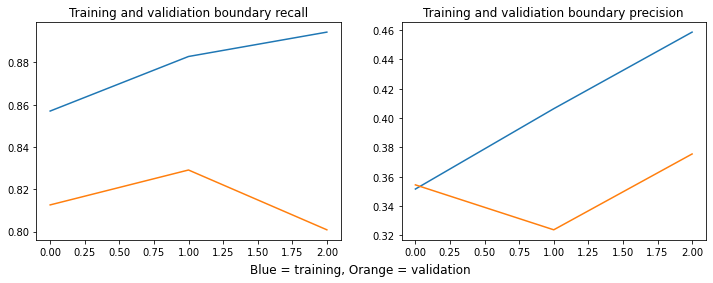

In [60]:
num_epochs = range(0,3)
bound_recall = statistics.history['boundary_recall']
val_bound_recall = statistics.history['val_boundary_recall']
bound_precision = statistics.history['boundary_precision']
val_bound_precision = statistics.history['val_boundary_precision']
plt.figure(figsize=(12,4))
plt.figtext(0.5, 0.01, "Blue = training, Orange = validation", wrap=True, horizontalalignment='center', fontsize=12)
plt.subplot(121)
plt.title("Training and validiation boundary recall")
plt.plot(num_epochs, bound_recall,val_bound_recall)
plt.subplot(122)
plt.title("Training and validiation boundary precision")
plt.plot(num_epochs, bound_precision,val_bound_precision)

In [ ]:
model.save_weights(config_vars["model_file"])

#### Model 3: Model 2 + augmented images (rotation, crop, flip, illumination)

In [91]:
experiment_name = 'model_3'

config_vars = utils.dirtools.setup_experiment(config_vars, experiment_name)

data_partitions = utils.dirtools.read_data_partitions(config_vars)

#config_vars

In [94]:
#training = all_images[1:]
accumulated_val_boundary_precision = 0
accumulated_val_loss = 0

for i in range(0,9):
    test = [all_images[i]]
    training = [item for item in all_images if item not in test]
    # build model
    model = utils.model_builder.get_model_3_class(config_vars["crop_size"], config_vars["crop_size"], activation=None)
    model.load_weights('/home/fvitez/nuclei_detection/experiments/bbbc/model.hdf5')
    #model.summary()

    #loss = "categorical_crossentropy"
    loss = utils.objectives.weighted_crossentropy

    metrics = [keras.metrics.categorical_accuracy, 
               utils.metrics.channel_recall(channel=0, name="background_recall"), 
               utils.metrics.channel_precision(channel=0, name="background_precision"),
               utils.metrics.channel_recall(channel=1, name="interior_recall"), 
               utils.metrics.channel_precision(channel=1, name="interior_precision"),
               utils.metrics.channel_recall(channel=2, name="boundary_recall"), 
               utils.metrics.channel_precision(channel=2, name="boundary_precision"),
              ]

    optimizer = keras.optimizers.RMSprop(lr=config_vars["learning_rate"])

    model.compile(loss=loss, metrics=metrics, optimizer=optimizer)

    # Performance logging
    callback_csv = keras.callbacks.CSVLogger(filename=config_vars["csv_log_file"])

    callbacks=[callback_csv]
    
    #print(test)
    #print(training)
    #break
    data_partitions['training'] = training
    data_partitions['validation'] = test
    train_gen = utils.data_provider.random_sample_generator(
        config_vars["normalized_images_dir"],
        config_vars["boundary_labels_dir"],
        data_partitions["training"],
        config_vars["batch_size"],
        config_vars["pixel_depth"],
        config_vars["crop_size"],
        config_vars["crop_size"],
        config_vars["rescale_labels"],
        True
        
    )

    val_gen = utils.data_provider.single_data_from_images(
         config_vars["normalized_images_dir"],
         config_vars["boundary_labels_dir"],
         data_partitions["validation"],
         config_vars["val_batch_size"],
         config_vars["pixel_depth"],
         config_vars["crop_size"],
         config_vars["crop_size"],
         config_vars["rescale_labels"]
    )
    
    # TRAIN
    statistics = model.fit_generator(
        generator=train_gen,
        steps_per_epoch=5,
        #epochs=config_vars["epochs"],
        epochs = 3,
        validation_data=val_gen,
        validation_steps=1,
        callbacks=callbacks,
        verbose = 1
    )
    accumulated_val_boundary_precision += statistics.history['val_boundary_precision'][2]
    accumulated_val_loss += statistics.history['val_loss'][2]
    

    print(str(i) + " out of " + str(10) + ' Done! :)')

print("Mean validation boundary precision = " + str(accumulated_val_boundary_precision/10))
print("Mean validation loss = " + str(accumulated_val_loss/10))

    

/home/fvitez/nuclei_detection/utils/model_builder.py:16: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
  a = keras.layers.Convolution2D(64, 3, 3, **option_dict_conv)(x)
/home/fvitez/nuclei_detection/utils/model_builder.py:17: UserWarning: Update your `BatchNormalization` call to the Keras 2 API: `BatchNormalization(momentum=0.9)`
  a = keras.layers.BatchNormalization(**option_dict_bn)(a)
/home/fvitez/nuclei_detection/utils/model_builder.py:19: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
  a = keras.layers.Convolution2D(64, 3, 3, **option_dict_conv)(a)
/home/fvitez/nuclei_detection/utils/model_builder.py:20: UserWarning: Update your `BatchNormalization` call to the Keras 2 API: `BatchNormalization(momentum=0.9)`
  a = keras.layers.BatchNormalization(**option_dict_bn)(a)
/home/fvitez/nuclei_detection/utils/model_builder.py:25: UserWarning: Update you

Training with 9 images.
Epoch 1/3
5/5 [==============================] - 52s 10s/step - loss: 0.4643 - categorical_accuracy: 0.8755 - background_recall: 0.8752 - background_precision: 0.9993 - interior_recall: 0.8891 - interior_precision: 0.5155 - boundary_recall: 0.8328 - boundary_precision: 0.1565 - val_loss: 0.2162 - val_categorical_accuracy: 0.9502 - val_background_recall: 0.9559 - val_background_precision: 0.9998 - val_interior_recall: 0.7610 - val_interior_precision: 0.6527 - val_boundary_recall: 0.9634 - val_boundary_precision: 0.1133
Epoch 2/3
5/5 [==============================] - 42s 8s/step - loss: 0.2733 - categorical_accuracy: 0.9650 - background_recall: 0.9728 - background_precision: 0.9986 - interior_recall: 0.8809 - interior_precision: 0.8470 - boundary_recall: 0.8017 - boundary_precision: 0.2665 - val_loss: 0.1409 - val_categorical_accuracy: 0.9688 - val_background_recall: 0.9758 - val_background_precision: 0.9998 - val_interior_recall: 0.7444 - val_interior_precision:

/home/fvitez/nuclei_detection/utils/model_builder.py:16: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
  a = keras.layers.Convolution2D(64, 3, 3, **option_dict_conv)(x)
/home/fvitez/nuclei_detection/utils/model_builder.py:17: UserWarning: Update your `BatchNormalization` call to the Keras 2 API: `BatchNormalization(momentum=0.9)`
  a = keras.layers.BatchNormalization(**option_dict_bn)(a)
/home/fvitez/nuclei_detection/utils/model_builder.py:19: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
  a = keras.layers.Convolution2D(64, 3, 3, **option_dict_conv)(a)
/home/fvitez/nuclei_detection/utils/model_builder.py:20: UserWarning: Update your `BatchNormalization` call to the Keras 2 API: `BatchNormalization(momentum=0.9)`
  a = keras.layers.BatchNormalization(**option_dict_bn)(a)
/home/fvitez/nuclei_detection/utils/model_builder.py:25: UserWarning: Update you

Epoch 1/3
Training with 9 images.
5/5 [==============================] - 52s 10s/step - loss: 0.4631 - categorical_accuracy: 0.8739 - background_recall: 0.8732 - background_precision: 0.9993 - interior_recall: 0.8915 - interior_precision: 0.4870 - boundary_recall: 0.8308 - boundary_precision: 0.1502 - val_loss: 0.3916 - val_categorical_accuracy: 0.9171 - val_background_recall: 0.9337 - val_background_precision: 0.9974 - val_interior_recall: 0.7627 - val_interior_precision: 0.7484 - val_boundary_recall: 0.8508 - val_boundary_precision: 0.1750
Epoch 2/3
5/5 [==============================] - 42s 8s/step - loss: 0.2662 - categorical_accuracy: 0.9697 - background_recall: 0.9762 - background_precision: 0.9989 - interior_recall: 0.8924 - interior_precision: 0.8677 - boundary_recall: 0.8151 - boundary_precision: 0.2786 - val_loss: 0.3157 - val_categorical_accuracy: 0.9351 - val_background_recall: 0.9566 - val_background_precision: 0.9968 - val_interior_recall: 0.7367 - val_interior_precision:

/home/fvitez/nuclei_detection/utils/model_builder.py:16: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
  a = keras.layers.Convolution2D(64, 3, 3, **option_dict_conv)(x)
/home/fvitez/nuclei_detection/utils/model_builder.py:17: UserWarning: Update your `BatchNormalization` call to the Keras 2 API: `BatchNormalization(momentum=0.9)`
  a = keras.layers.BatchNormalization(**option_dict_bn)(a)
/home/fvitez/nuclei_detection/utils/model_builder.py:19: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
  a = keras.layers.Convolution2D(64, 3, 3, **option_dict_conv)(a)
/home/fvitez/nuclei_detection/utils/model_builder.py:20: UserWarning: Update your `BatchNormalization` call to the Keras 2 API: `BatchNormalization(momentum=0.9)`
  a = keras.layers.BatchNormalization(**option_dict_bn)(a)
/home/fvitez/nuclei_detection/utils/model_builder.py:25: UserWarning: Update you

Training with Epoch 1/3
9 images.
5/5 [==============================] - 51s 10s/step - loss: 0.4328 - categorical_accuracy: 0.8993 - background_recall: 0.9011 - background_precision: 0.9988 - interior_recall: 0.8858 - interior_precision: 0.5889 - boundary_recall: 0.8319 - boundary_precision: 0.1933 - val_loss: 0.2301 - val_categorical_accuracy: 0.9571 - val_background_recall: 0.9713 - val_background_precision: 0.9996 - val_interior_recall: 0.7672 - val_interior_precision: 0.9786 - val_boundary_recall: 0.9596 - val_boundary_precision: 0.2079
Epoch 2/3
5/5 [==============================] - 42s 8s/step - loss: 0.2569 - categorical_accuracy: 0.9704 - background_recall: 0.9778 - background_precision: 0.9986 - interior_recall: 0.8902 - interior_precision: 0.8836 - boundary_recall: 0.7997 - boundary_precision: 0.2889 - val_loss: 0.1855 - val_categorical_accuracy: 0.9725 - val_background_recall: 0.9866 - val_background_precision: 0.9988 - val_interior_recall: 0.7961 - val_interior_precision:

/home/fvitez/nuclei_detection/utils/model_builder.py:16: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
  a = keras.layers.Convolution2D(64, 3, 3, **option_dict_conv)(x)
/home/fvitez/nuclei_detection/utils/model_builder.py:17: UserWarning: Update your `BatchNormalization` call to the Keras 2 API: `BatchNormalization(momentum=0.9)`
  a = keras.layers.BatchNormalization(**option_dict_bn)(a)
/home/fvitez/nuclei_detection/utils/model_builder.py:19: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
  a = keras.layers.Convolution2D(64, 3, 3, **option_dict_conv)(a)
/home/fvitez/nuclei_detection/utils/model_builder.py:20: UserWarning: Update your `BatchNormalization` call to the Keras 2 API: `BatchNormalization(momentum=0.9)`
  a = keras.layers.BatchNormalization(**option_dict_bn)(a)
/home/fvitez/nuclei_detection/utils/model_builder.py:25: UserWarning: Update you

Epoch 1/3
Training with 9 images.
5/5 [==============================] - 53s 11s/step - loss: 0.4253 - categorical_accuracy: 0.9014 - background_recall: 0.9031 - background_precision: 0.9989 - interior_recall: 0.8879 - interior_precision: 0.5916 - boundary_recall: 0.8346 - boundary_precision: 0.1968 - val_loss: 0.0587 - val_categorical_accuracy: 0.9920 - val_background_recall: 0.9952 - val_background_precision: 1.0000 - val_interior_recall: 0.7873 - val_interior_precision: 0.9661 - val_boundary_recall: 0.9632 - val_boundary_precision: 0.2408
Epoch 2/3
5/5 [==============================] - 42s 8s/step - loss: 0.2561 - categorical_accuracy: 0.9705 - background_recall: 0.9780 - background_precision: 0.9986 - interior_recall: 0.8906 - interior_precision: 0.8879 - boundary_recall: 0.8022 - boundary_precision: 0.2934 - val_loss: 0.0607 - val_categorical_accuracy: 0.9929 - val_background_recall: 0.9965 - val_background_precision: 1.0000 - val_interior_recall: 0.7546 - val_interior_precision:

/home/fvitez/nuclei_detection/utils/model_builder.py:16: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
  a = keras.layers.Convolution2D(64, 3, 3, **option_dict_conv)(x)
/home/fvitez/nuclei_detection/utils/model_builder.py:17: UserWarning: Update your `BatchNormalization` call to the Keras 2 API: `BatchNormalization(momentum=0.9)`
  a = keras.layers.BatchNormalization(**option_dict_bn)(a)
/home/fvitez/nuclei_detection/utils/model_builder.py:19: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
  a = keras.layers.Convolution2D(64, 3, 3, **option_dict_conv)(a)
/home/fvitez/nuclei_detection/utils/model_builder.py:20: UserWarning: Update your `BatchNormalization` call to the Keras 2 API: `BatchNormalization(momentum=0.9)`
  a = keras.layers.BatchNormalization(**option_dict_bn)(a)
/home/fvitez/nuclei_detection/utils/model_builder.py:25: UserWarning: Update you

Training with 9 images.
Epoch 1/3
5/5 [==============================] - 52s 10s/step - loss: 0.4398 - categorical_accuracy: 0.8879 - background_recall: 0.8880 - background_precision: 0.9992 - interior_recall: 0.8973 - interior_precision: 0.4949 - boundary_recall: 0.8245 - boundary_precision: 0.1738 - val_loss: 0.2908 - val_categorical_accuracy: 0.9548 - val_background_recall: 0.9737 - val_background_precision: 0.9990 - val_interior_recall: 0.7909 - val_interior_precision: 0.9134 - val_boundary_recall: 0.8850 - val_boundary_precision: 0.2699
Epoch 2/3
5/5 [==============================] - 42s 8s/step - loss: 0.2706 - categorical_accuracy: 0.9667 - background_recall: 0.9724 - background_precision: 0.9991 - interior_recall: 0.8930 - interior_precision: 0.8159 - boundary_recall: 0.8132 - boundary_precision: 0.2500 - val_loss: 0.2605 - val_categorical_accuracy: 0.9624 - val_background_recall: 0.9850 - val_background_precision: 0.9975 - val_interior_recall: 0.7757 - val_interior_precision:

/home/fvitez/nuclei_detection/utils/model_builder.py:16: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
  a = keras.layers.Convolution2D(64, 3, 3, **option_dict_conv)(x)
/home/fvitez/nuclei_detection/utils/model_builder.py:17: UserWarning: Update your `BatchNormalization` call to the Keras 2 API: `BatchNormalization(momentum=0.9)`
  a = keras.layers.BatchNormalization(**option_dict_bn)(a)
/home/fvitez/nuclei_detection/utils/model_builder.py:19: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
  a = keras.layers.Convolution2D(64, 3, 3, **option_dict_conv)(a)
/home/fvitez/nuclei_detection/utils/model_builder.py:20: UserWarning: Update your `BatchNormalization` call to the Keras 2 API: `BatchNormalization(momentum=0.9)`
  a = keras.layers.BatchNormalization(**option_dict_bn)(a)
/home/fvitez/nuclei_detection/utils/model_builder.py:25: UserWarning: Update you

Training with 9 images.
Epoch 1/3
5/5 [==============================] - 52s 10s/step - loss: 0.4437 - categorical_accuracy: 0.8948 - background_recall: 0.8963 - background_precision: 0.9992 - interior_recall: 0.8922 - interior_precision: 0.5608 - boundary_recall: 0.8278 - boundary_precision: 0.1708 - val_loss: 0.3178 - val_categorical_accuracy: 0.9465 - val_background_recall: 0.9672 - val_background_precision: 0.9974 - val_interior_recall: 0.7721 - val_interior_precision: 0.9433 - val_boundary_recall: 0.8284 - val_boundary_precision: 0.2291
Epoch 2/3
5/5 [==============================] - 42s 8s/step - loss: 0.2822 - categorical_accuracy: 0.9665 - background_recall: 0.9724 - background_precision: 0.9990 - interior_recall: 0.8936 - interior_precision: 0.8235 - boundary_recall: 0.8126 - boundary_precision: 0.2542 - val_loss: 0.3541 - val_categorical_accuracy: 0.9407 - val_background_recall: 0.9636 - val_background_precision: 0.9990 - val_interior_recall: 0.7317 - val_interior_precision:

/home/fvitez/nuclei_detection/utils/model_builder.py:16: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
  a = keras.layers.Convolution2D(64, 3, 3, **option_dict_conv)(x)
/home/fvitez/nuclei_detection/utils/model_builder.py:17: UserWarning: Update your `BatchNormalization` call to the Keras 2 API: `BatchNormalization(momentum=0.9)`
  a = keras.layers.BatchNormalization(**option_dict_bn)(a)
/home/fvitez/nuclei_detection/utils/model_builder.py:19: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
  a = keras.layers.Convolution2D(64, 3, 3, **option_dict_conv)(a)
/home/fvitez/nuclei_detection/utils/model_builder.py:20: UserWarning: Update your `BatchNormalization` call to the Keras 2 API: `BatchNormalization(momentum=0.9)`
  a = keras.layers.BatchNormalization(**option_dict_bn)(a)
/home/fvitez/nuclei_detection/utils/model_builder.py:25: UserWarning: Update you

Epoch 1/3
Training with 9 images.
5/5 [==============================] - 51s 10s/step - loss: 0.4320 - categorical_accuracy: 0.8977 - background_recall: 0.8993 - background_precision: 0.9992 - interior_recall: 0.8912 - interior_precision: 0.5972 - boundary_recall: 0.8457 - boundary_precision: 0.1812 - val_loss: 0.1226 - val_categorical_accuracy: 0.9811 - val_background_recall: 0.9849 - val_background_precision: 1.0000 - val_interior_recall: 0.8166 - val_interior_precision: 0.8709 - val_boundary_recall: 0.6616 - val_boundary_precision: 0.1060
Epoch 2/3
5/5 [==============================] - 42s 8s/step - loss: 0.2547 - categorical_accuracy: 0.9724 - background_recall: 0.9801 - background_precision: 0.9986 - interior_recall: 0.8958 - interior_precision: 0.9024 - boundary_recall: 0.8085 - boundary_precision: 0.3132 - val_loss: 0.1124 - val_categorical_accuracy: 0.9807 - val_background_recall: 0.9857 - val_background_precision: 1.0000 - val_interior_recall: 0.7236 - val_interior_precision:

/home/fvitez/nuclei_detection/utils/model_builder.py:16: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
  a = keras.layers.Convolution2D(64, 3, 3, **option_dict_conv)(x)
/home/fvitez/nuclei_detection/utils/model_builder.py:17: UserWarning: Update your `BatchNormalization` call to the Keras 2 API: `BatchNormalization(momentum=0.9)`
  a = keras.layers.BatchNormalization(**option_dict_bn)(a)
/home/fvitez/nuclei_detection/utils/model_builder.py:19: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
  a = keras.layers.Convolution2D(64, 3, 3, **option_dict_conv)(a)
/home/fvitez/nuclei_detection/utils/model_builder.py:20: UserWarning: Update your `BatchNormalization` call to the Keras 2 API: `BatchNormalization(momentum=0.9)`
  a = keras.layers.BatchNormalization(**option_dict_bn)(a)
/home/fvitez/nuclei_detection/utils/model_builder.py:25: UserWarning: Update you

Epoch 1/3
Training with 9 images.
5/5 [==============================] - 51s 10s/step - loss: 0.4589 - categorical_accuracy: 0.8622 - background_recall: 0.8611 - background_precision: 0.9992 - interior_recall: 0.8819 - interior_precision: 0.4315 - boundary_recall: 0.8448 - boundary_precision: 0.1674 - val_loss: 0.3751 - val_categorical_accuracy: 0.9599 - val_background_recall: 0.9668 - val_background_precision: 0.9998 - val_interior_recall: 0.9414 - val_interior_precision: 0.8049 - val_boundary_recall: 0.5199 - val_boundary_precision: 0.1923
Epoch 2/3
5/5 [==============================] - 42s 8s/step - loss: 0.2632 - categorical_accuracy: 0.9720 - background_recall: 0.9793 - background_precision: 0.9988 - interior_recall: 0.9007 - interior_precision: 0.8767 - boundary_recall: 0.7904 - boundary_precision: 0.3123 - val_loss: 0.2670 - val_categorical_accuracy: 0.9607 - val_background_recall: 0.9727 - val_background_precision: 0.9997 - val_interior_recall: 0.8218 - val_interior_precision:

/home/fvitez/nuclei_detection/utils/model_builder.py:16: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
  a = keras.layers.Convolution2D(64, 3, 3, **option_dict_conv)(x)
/home/fvitez/nuclei_detection/utils/model_builder.py:17: UserWarning: Update your `BatchNormalization` call to the Keras 2 API: `BatchNormalization(momentum=0.9)`
  a = keras.layers.BatchNormalization(**option_dict_bn)(a)
/home/fvitez/nuclei_detection/utils/model_builder.py:19: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
  a = keras.layers.Convolution2D(64, 3, 3, **option_dict_conv)(a)
/home/fvitez/nuclei_detection/utils/model_builder.py:20: UserWarning: Update your `BatchNormalization` call to the Keras 2 API: `BatchNormalization(momentum=0.9)`
  a = keras.layers.BatchNormalization(**option_dict_bn)(a)
/home/fvitez/nuclei_detection/utils/model_builder.py:25: UserWarning: Update you

Epoch 1/3
Training with 9 images.
5/5 [==============================] - 52s 10s/step - loss: 0.4676 - categorical_accuracy: 0.8679 - background_recall: 0.8677 - background_precision: 0.9991 - interior_recall: 0.8786 - interior_precision: 0.4518 - boundary_recall: 0.8116 - boundary_precision: 0.1706 - val_loss: 0.3297 - val_categorical_accuracy: 0.9503 - val_background_recall: 0.9569 - val_background_precision: 0.9999 - val_interior_recall: 0.8734 - val_interior_precision: 0.8066 - val_boundary_recall: 0.8210 - val_boundary_precision: 0.1930
Epoch 2/3
5/5 [==============================] - 42s 8s/step - loss: 0.2593 - categorical_accuracy: 0.9709 - background_recall: 0.9779 - background_precision: 0.9988 - interior_recall: 0.8975 - interior_precision: 0.8632 - boundary_recall: 0.7916 - boundary_precision: 0.3003 - val_loss: 0.2329 - val_categorical_accuracy: 0.9610 - val_background_recall: 0.9731 - val_background_precision: 0.9998 - val_interior_recall: 0.7806 - val_interior_precision:

> The model that uses augmentation has both higher boundary precision and less validation loss

#### Train the best model (model 3) 

> Take the best model
> 
> For 10 iteratations:
    > * Create a new model (with best model settings)
    > * Train it on 9/10 images, save model and log file
>
> Let each model make predictions on its left out image and evaluate the mean performance 


In [104]:
all_images

['MFGTMPcx7_170702000001_G07f02d0.png',
 'MFGTMPcx7_170702090001_B22f15d0.png',
 'MFGTMPcx7_170702090001_N06f14d0.png',
 'MFGTMPcx7_170731090001_K24f10d0.png',
 'MFGTMPcx7_170801050001_A01f03d0.png',
 'MFGTMPcx7_170803210001_A01f29d0.png',
 'MFGTMPcx7_170803210001_A05f27d0.png',
 'MFGTMPcx7_170803210001_B18f27d0.png',
 'MFGTMPcx7_170803210001_B19f26d0.png',
 'MFGTMPcx7_170803210001_J12f29d0.png']

In [112]:
test = [all_images[0]]
training = [item for item in all_images if item not in test]

In [116]:
for i in range(0,9):
    print("Training the " + str(i+1) + "th model")
    
    test = [all_images[i]]
    training = [item for item in all_images if item not in test]
    
    experiment_name = 'model3_' + all_images[i][:-4]

    config_vars = utils.dirtools.setup_experiment(config_vars, experiment_name)

    data_partitions = utils.dirtools.read_data_partitions(config_vars)

    #config_vars
    
    # build model
    model = utils.model_builder.get_model_3_class(config_vars["crop_size"], config_vars["crop_size"], activation=None)
    model.load_weights('/home/fvitez/nuclei_detection/model.hdf5')
    #model.load_weights('/home/fvitez/nuclei_detection/experiments/bbbc/model.hdf5')
    #model.summary()
    


    #loss = "categorical_crossentropy"
    loss = utils.objectives.weighted_crossentropy

    metrics = [keras.metrics.categorical_accuracy, 
               utils.metrics.channel_recall(channel=0, name="background_recall"), 
               utils.metrics.channel_precision(channel=0, name="background_precision"),
               utils.metrics.channel_recall(channel=1, name="interior_recall"), 
               utils.metrics.channel_precision(channel=1, name="interior_precision"),
               utils.metrics.channel_recall(channel=2, name="boundary_recall"), 
               utils.metrics.channel_precision(channel=2, name="boundary_precision"),
              ]

    optimizer = keras.optimizers.RMSprop(lr=config_vars["learning_rate"])

    model.compile(loss=loss, metrics=metrics, optimizer=optimizer)

    # Performance logging
    callback_csv = keras.callbacks.CSVLogger(filename=config_vars["csv_log_file"])

    callbacks=[callback_csv]

    #print(test)
    #print(training)
    #break
    data_partitions['training'] = training
    data_partitions['validation'] = test
    train_gen = utils.data_provider.random_sample_generator(
        config_vars["normalized_images_dir"],
        config_vars["boundary_labels_dir"],
        data_partitions["training"],
        config_vars["batch_size"],
        config_vars["pixel_depth"],
        config_vars["crop_size"],
        config_vars["crop_size"],
        config_vars["rescale_labels"],
        True

    )

    val_gen = utils.data_provider.single_data_from_images(
         config_vars["normalized_images_dir"],
         config_vars["boundary_labels_dir"],
         data_partitions["validation"],
         config_vars["val_batch_size"],
         config_vars["pixel_depth"],
         config_vars["crop_size"],
         config_vars["crop_size"],
         config_vars["rescale_labels"]
    )

    # TRAIN
    statistics = model.fit_generator(
        generator=train_gen,
        steps_per_epoch=200,
        #epochs=config_vars["epochs"],
        epochs = 5,
        validation_data=val_gen,
        validation_steps=1,
        callbacks=callbacks,
        verbose = 1
    )
    
    model.save_weights(config_vars["model_file"])
    



    

Training the 1th model


/home/fvitez/nuclei_detection/utils/model_builder.py:16: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
  a = keras.layers.Convolution2D(64, 3, 3, **option_dict_conv)(x)
/home/fvitez/nuclei_detection/utils/model_builder.py:17: UserWarning: Update your `BatchNormalization` call to the Keras 2 API: `BatchNormalization(momentum=0.9)`
  a = keras.layers.BatchNormalization(**option_dict_bn)(a)
/home/fvitez/nuclei_detection/utils/model_builder.py:19: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
  a = keras.layers.Convolution2D(64, 3, 3, **option_dict_conv)(a)
/home/fvitez/nuclei_detection/utils/model_builder.py:20: UserWarning: Update your `BatchNormalization` call to the Keras 2 API: `BatchNormalization(momentum=0.9)`
  a = keras.layers.BatchNormalization(**option_dict_bn)(a)
/home/fvitez/nuclei_detection/utils/model_builder.py:25: UserWarning: Update you

Training with 9 images.
Epoch 1/5
200/200 [==============================] - 1893s 9s/step - loss: 0.1378 - categorical_accuracy: 0.9841 - background_recall: 0.9903 - background_precision: 0.9989 - interior_recall: 0.9074 - interior_precision: 0.9684 - boundary_recall: 0.8480 - boundary_precision: 0.4225 - val_loss: 0.0580 - val_categorical_accuracy: 0.9951 - val_background_recall: 0.9984 - val_background_precision: 0.9994 - val_interior_recall: 0.9124 - val_interior_precision: 0.9966 - val_boundary_recall: 0.8598 - val_boundary_precision: 0.5072
Epoch 2/5
200/200 [==============================] - 1740s 9s/step - loss: 0.1066 - categorical_accuracy: 0.9892 - background_recall: 0.9949 - background_precision: 0.9990 - interior_recall: 0.9223 - interior_precision: 0.9858 - boundary_recall: 0.8519 - boundary_precision: 0.4829 - val_loss: 0.0569 - val_categorical_accuracy: 0.9946 - val_background_recall: 0.9979 - val_background_precision: 0.9992 - val_interior_recall: 0.9186 - val_interior

/home/fvitez/nuclei_detection/utils/model_builder.py:16: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
  a = keras.layers.Convolution2D(64, 3, 3, **option_dict_conv)(x)
/home/fvitez/nuclei_detection/utils/model_builder.py:17: UserWarning: Update your `BatchNormalization` call to the Keras 2 API: `BatchNormalization(momentum=0.9)`
  a = keras.layers.BatchNormalization(**option_dict_bn)(a)
/home/fvitez/nuclei_detection/utils/model_builder.py:19: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
  a = keras.layers.Convolution2D(64, 3, 3, **option_dict_conv)(a)
/home/fvitez/nuclei_detection/utils/model_builder.py:20: UserWarning: Update your `BatchNormalization` call to the Keras 2 API: `BatchNormalization(momentum=0.9)`
  a = keras.layers.BatchNormalization(**option_dict_bn)(a)
/home/fvitez/nuclei_detection/utils/model_builder.py:25: UserWarning: Update you

Epoch 1/5
Training with 9 images.
 22/200 [==>...........................] - ETA: 28:02 - loss: 0.2398 - categorical_accuracy: 0.9622 - background_recall: 0.9669 - background_precision: 0.9991 - interior_recall: 0.9003 - interior_precision: 0.8780 - boundary_recall: 0.8416 - boundary_precision: 0.3183

KeyboardInterrupt: 